# Prototyping Loiter Detection and Airspeed Calibration Post-Processing

In [1]:
### Definining name of analysis ###
name = '2023-08-12_AirspeedCalibrationPost_June15_2022'
data_path = '../../data/'
data_folder = 'createv-2022-06-15'
file_name = 'june15_2022.BIN'
datasave_path = data_path+data_folder+'/'
result_path = '../Results/'+name+'/'
figure_path = '../Figures/'+name+'/'

In [2]:
from os import sys
import os
sys.path.append('../../')

# Getting packages #
%matplotlib widget

from matplotlib import pyplot as plt
from matplotlib.widgets import SpanSelector
import numpy as np
import pandas as pd
from scipy import optimize 
from scipy.io import savemat
from scipy import odr
import pandas as pd
import decimal
import math

import plotly.express as px

import main
from main import flight
from main import analysis
import propellers
import motors
from aircraft import airplane
import cl_finders

import data_exporter
import datetime

### Creating Folders for Results/Data ###
if not os.path.exists(result_path):
    os.makedirs(result_path)
if not os.path.exists(figure_path):
    os.makedirs(figure_path)

# Setting Plot Defaults
plt.style.use('../../basic_plotter.mplstyle')

In [3]:
# Vehicle parameters
prop = propellers.aeronaut20x8() # Using aeronaut 20x8 for this flight
motor = motors.U7V2_280KV()  # Using U7 V2 motor

mass = 12.727 # Estimated with virtual bolt included
span = 6.28
chord = 0.395
createv = airplane(mass, chord, span)

P_systems = 4 # Amount of power consumed by everything except the ESC & motor

highorderpolar = True

In [4]:
# Importing data, specifying import characteristics, backing up results
rate = "10ms"
interpolateM = "linear"
processor = "CREATeV_2022"

rawdata_name = data_folder+'/'+file_name.split('.')[0]+'_'+rate+'_'+interpolateM+'_'+processor+'.pkl'

# Checking if the data is already pickled for analysis
if os.path.exists(data_path+rawdata_name):
    df = pd.read_pickle(data_path+rawdata_name)
else:
    df = main.get_data(processor, data_folder+'/'+file_name, rate)
    df = df.interpolate(method=interpolateM)
    pd.to_pickle(df, data_path+rawdata_name) # Storing parsed data

In [5]:
print(df.Airspeed[-1])
print(df.Airspeed[len(df)-1])
print(df.shape)
indices = np.arange(0, df.shape[0])
print(len(df.Airspeed))
print(indices.shape)

df["index_ref"] = indices

0.6034334897994995
0.6034334897994995
(1497703, 52)
1497703
(1497703,)


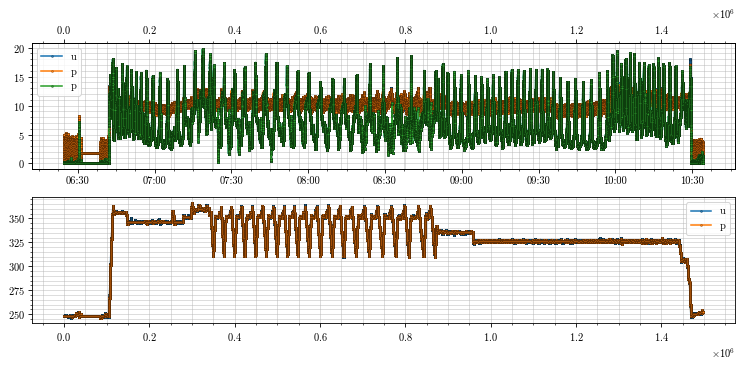

In [6]:
## Generating Map Plots Descending ## 

token = "pk.eyJ1Ijoid2tlbXA5NCIsImEiOiJjbGI0NHJuemkwMmF2M29zM24xcTlpNXVjIn0.qSiAc29MftNSOK2DOpRggw"
color_scale = [(0, 'orange'), (1,'red')]

fig = plt.figure(figsize=(10,5), dpi=75)
ax1 = plt.subplot(2,1,1)
ax1.plot(df.index, df.Groundspeed_GPS)
ax2 = ax1.twiny()
ax2.plot(df.index_ref, df.Airspeed_Sensor0, label='Airspeed 0')
ax2.plot(df.index_ref, df.Airspeed_Sensor1, label='Airspeed 1')
ax2.plot(df.index_ref, df.Groundspeed_GPS, label='Ground speed')
ax2.legend("upper left")

ax3 = plt.subplot(2, 1, 2, sharex=ax2)
ax3.plot(df.index_ref, df.Altitude_GPS, label='GPS Altitude')
ax3.plot(df.index_ref, df.Altitude, label='Altitude')
ax3.legend("upper left")
plt.show()

segment_times = np.array([])

def onselect(xmin, xmax):
    segment_times = segment_times.tolist()
    xmin = round(math.ceil(decimal.Decimal(xmin)))
    xmax = round(math.ceil(decimal.Decimal(xmax)))
    t_min = df.index[xmin]
    t_max = df.index[xmax]
    segment_interval = [str(t_min.hour).zfill(2)+':'+str(t_min.minute).zfill(2)+':'+str(t_max.second).zfill(2), str(t_max.hour).zfill(2)+':'+str(t_max.minute).zfill(2)+':'+str(t_max.second).zfill(2)]
    segment_times.append(segment_interval)

    segment_times = np.array(segment_times)
    print(segment_times)
    # Try plotting time on the x axis, and overplotting index as the real axis.  
    # 1. Generate plot of airspeeds vs the absolute index
    # 2. Create a dummy series showing the time index

span = SpanSelector(
    ax2,
    onselect,
    "horizontal",
    useblit=True,
    props=dict(alpha=0.5, facecolor="tab:blue"),
    interactive=True,
    button=3,
    drag_from_anywhere=True
)
# Set useblit=True on most backends for enhanced performance.

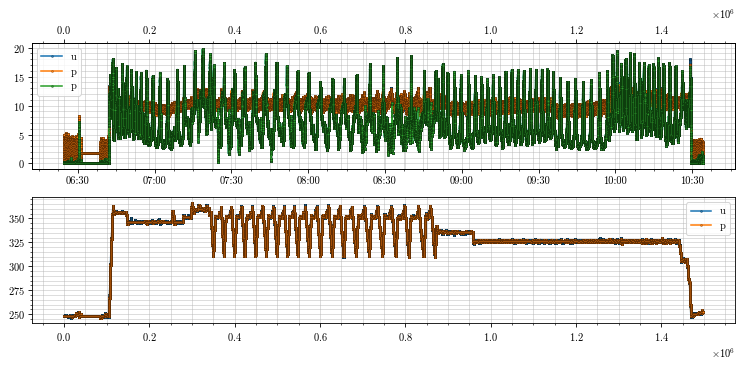

In [7]:
## Generating Map Plots Descending ## 

token = "pk.eyJ1Ijoid2tlbXA5NCIsImEiOiJjbGI0NHJuemkwMmF2M29zM24xcTlpNXVjIn0.qSiAc29MftNSOK2DOpRggw"
color_scale = [(0, 'orange'), (1,'red')]

fig = plt.figure(figsize=(10,5), dpi=75)
ax1 = plt.subplot(2,1,1)
ax1.plot(df.index, df.Groundspeed_GPS)
ax2 = ax1.twiny()
ax2.plot(df.index_ref, df.Airspeed_Sensor0, label='Airspeed 0')
ax2.plot(df.index_ref, df.Airspeed_Sensor1, label='Airspeed 1')
ax2.plot(df.index_ref, df.Groundspeed_GPS, label='Ground speed')
ax2.legend("upper left")

ax3 = plt.subplot(2, 1, 2, sharex=ax2)
ax3.plot(df.index_ref, df.Altitude_GPS, label='GPS Altitude')
ax3.plot(df.index_ref, df.Altitude, label='Altitude')
ax3.legend("upper left")
plt.show()

x_s = []

def onselect(xmin, xmax):
    print(xmin, xmax)
    xmin = round(math.ceil(decimal.Decimal(xmin)))

    xmax = decimal.Decimal(xmax)
    xmax = math.floor(xmax)
    xmax = round(xmax)
    print(xmin, xmax)
    print(df.index[xmin])
    print(df.index[xmax])

    x_s.append(df.index[xmin])
    print(x_s)
    
    df_sample = df.iloc[xmin:xmax]
    print(np.mean(df_sample.Airspeed_Sensor0))

    fig2 = px.scatter_mapbox(df_sample, 
                        lat="Latitude", 
                        lon="Longitude", 
                        hover_name=df_sample.index, 
                        #hover_data=["Address", "Listed"],
                        color="Airspeed_Sensor0",
                        color_continuous_scale='jet',
                        #size="Listed",
                        zoom=15.5, 
                        height=600,
                        width=900,
                        labels={"Airspeed": 'Airspeed (m/s)'},
                        center={'lat':44.0427, 'lon':-79.845},
                        template='presentation')
    fig2.update_layout(mapbox_style="satellite", mapbox_accesstoken=token)
    fig2.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    fig2.show()

    # Try plotting time on the x axis, and overplotting index as the real axis.  
    # 1. Generate plot of airspeeds vs the absolute index
    # 2. Create a dummy series showing the time index

span = SpanSelector(
    ax2,
    onselect,
    "horizontal",
    useblit=True,
    props=dict(alpha=0.5, facecolor="tab:blue"),
    interactive=True,
    button=3,
    drag_from_anywhere=True
)
# Set useblit=True on most backends for enhanced performance.

In [8]:
t = x_s[0]
str(t.hour).zfill(2)
str(t.minute).zfill(2)
str(t.second).zfill(2)
t.day

IndexError: list index out of range

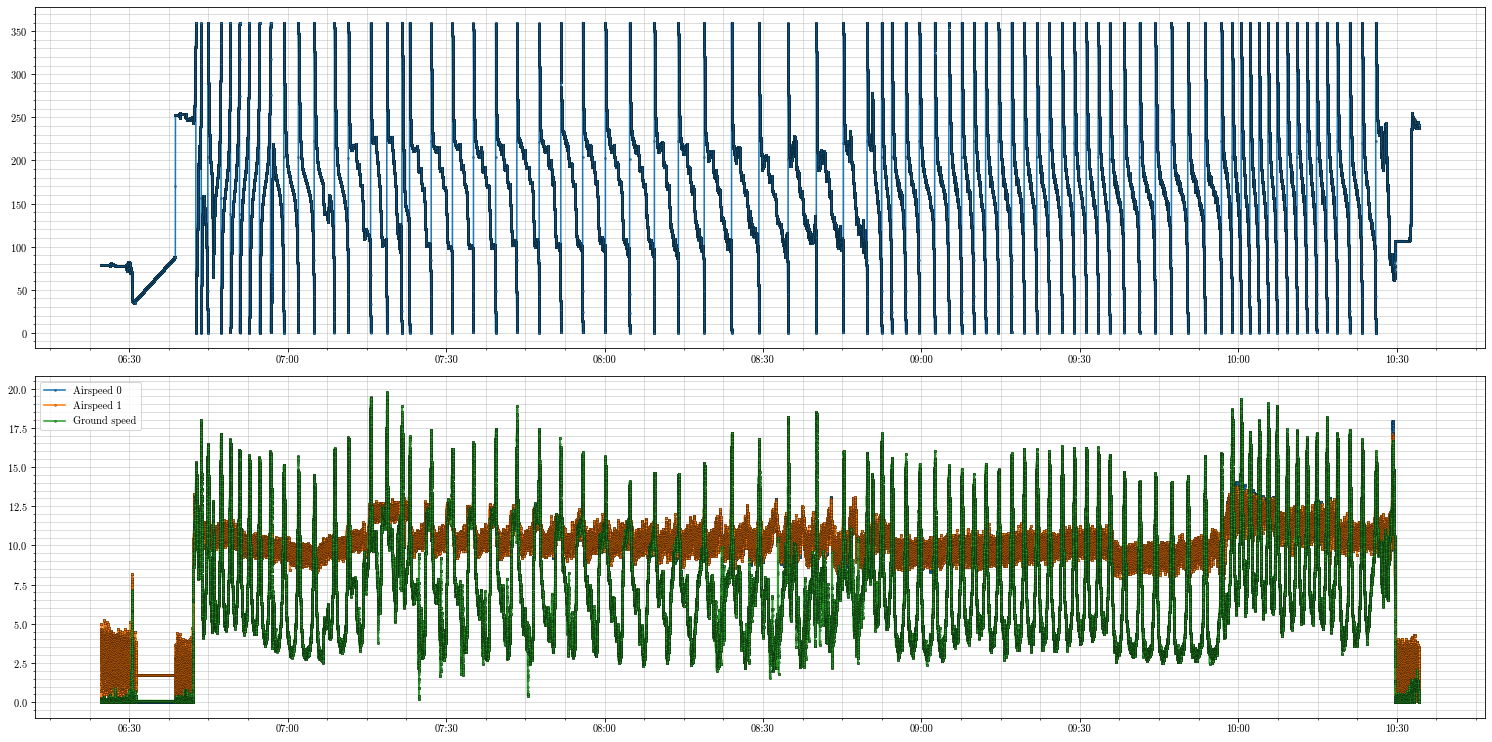

In [9]:
fig = plt.figure(figsize=(20,10), dpi=75)
ax1 = plt.subplot(2,1,1)
ax1.plot(df.index, df.Heading)

ax2 = plt.subplot(2,1,2, sharex=ax1)
ax2.plot(df.index, df.Airspeed_Sensor0, label='Airspeed 0')
ax2.plot(df.index, df.Airspeed_Sensor1, label='Airspeed 1')
ax2.plot(df.index, df.Groundspeed_GPS, label='Ground speed')
ax2.legend(loc='upper left')
plt.show()

In [10]:
# Generating separate loiters - Masking the data by heading angles
range = 20 # Range of heading in degrees
heading_mask = (df["Heading"] < 180 + (range/2)) & (df["Heading"] > 180-(range/2))
heading_mask = heading_mask.replace({True: 1, False: 0})
edge_mask = heading_mask.diff(periods=1)
loiter_mask = (edge_mask == 1) # Mask with True for beginning of each loiter
loiter_times = loiter_mask.loc[loiter_mask == True] # Loiter Series storing loiter number, start time, end time. 

In [11]:
# Method #2 using discontinuity of heading angle
heading_array = df.Heading.to_numpy()
jump = np.diff(heading_array)
jump = np.abs(np.insert(jump, 0, -1, axis=0))

edge_mask = np.logical_and(jump >= 80, heading_array > 0.95 * 360)

loiter_times = loiter_mask.loc[edge_mask == True] # Loiter Series storing loiter number, start time, end time. 
loiter_numbers = np.arange(0, 20) # Selecting the nth loiter of the flight for analysis #

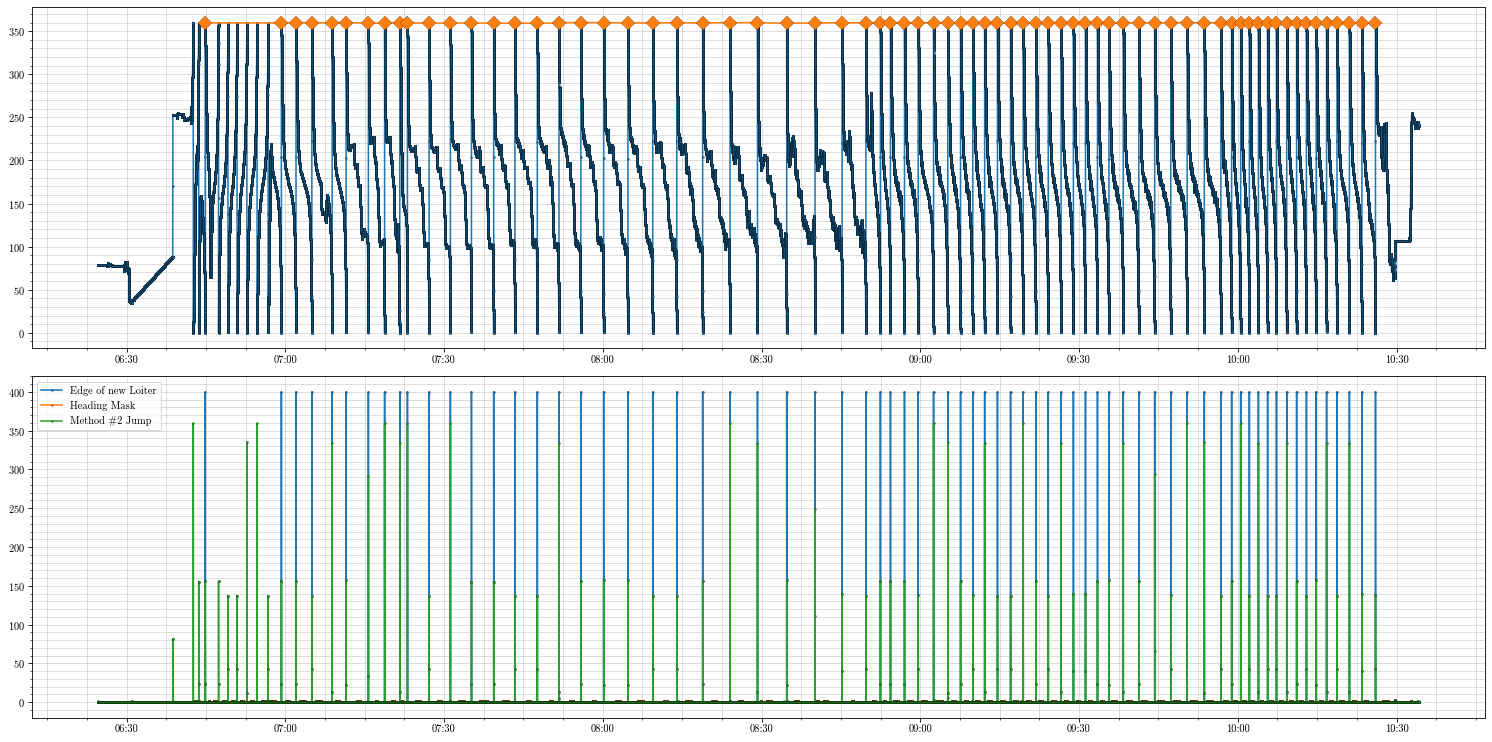

In [12]:
fig = plt.figure(figsize=(20,10), dpi=75)
ax1 = plt.subplot(2,1,1)
ax1.plot(df.index, df.Heading)
ax1.plot(df.index[edge_mask == True], df.Heading[edge_mask == True], marker='D', markersize=10, linestyle=None)

ax2 = plt.subplot(2,1,2, sharex=ax1)
ax2.plot(df.index, edge_mask*400, label='Edge of new Loiter')
ax2.plot(df.index, heading_mask, label="Heading Mask")
ax2.plot(df.index, jump, label="Method #2 Jump")
ax2.legend(loc='upper left')
plt.show()

In [13]:
loiter_numbers = np.arange(26, 69) # Selecting the nth loiter of the flight for analysis #

# Selection of Loiters

The loiter numbers are from 30 to 69 for the constant airspeed cruise testing.  These loiters the ones that need to be analyzed for the airspeed calibration.  

## Method of Airspeed Calibration Analysis

1. Determine the time series data to be selected (Single airspeed, circular loiters, no changes to the demanded airspeed in range)
2. Pre-process the time series data, to find the loiter positions, $\theta$
3. Perform the curve fitting to determine the magnitude of the wind, and airspeed
4. Plot the curve fitted ground speed, actual ground speed, demanded airspeed, and sensor airspeeds, and fitted airspeed all on same plot
5. Determine the adjustment to be made to airspeed (Should this be defined by asratio instead of offsetting just the sensor airspeed output?)

## ArduPilot Code

### Airspeed Variables
* airspeed
* differential pressure
* temperature (celsius)
* rawpressure (corrected)
* offset
* use

/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_51434/669922826.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segment["PowerElectrical"] = segment.EscVoltage * segment.EscCurrent
/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_51434/669922826.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segment["PowerElectrical"] = segment.EscVoltage * segment.EscCurrent
/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_51434/669922826.py:8: SettingWithCopyWarning: 
A value is try

0 days 00:05:07.560000
0
0 days 00:04:29.600000
1
0 days 00:02:44.300000
2
0 days 00:01:54.200000
3
0 days 00:02:39
4
0 days 00:02:35.500000
5
0 days 00:02:54.130000
6
0 days 00:02:41.200000
7
0 days 00:02:24.770000
8
0 days 00:02:19.100000
9
0 days 00:02:14.130000
10
0 days 00:02:25.270000
11
0 days 00:02:28.600000
12
0 days 00:02:23.430000
13
0 days 00:02:23.270000
14
0 days 00:02:20.700000
15
0 days 00:02:25.330000
16


/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_51434/669922826.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segment["PowerElectrical"] = segment.EscVoltage * segment.EscCurrent
/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_51434/669922826.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segment["PowerElectrical"] = segment.EscVoltage * segment.EscCurrent
/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_51434/669922826.py:8: SettingWithCopyWarning: 
A value is try

0 days 00:02:19.670000
17
0 days 00:02:17
18
0 days 00:02:15.900000
19
0 days 00:02:10
20
0 days 00:02:42.430000
21
0 days 00:02:56.570000
22
0 days 00:02:59.640000
23
0 days 00:03:02.660000
24
0 days 00:03:05.730000
25
0 days 00:03:14.500000
26
0 days 00:03:07.770000
27
0 days 00:02:01.900000
28
0 days 00:01:42.630000
29
0 days 00:01:38.270000
30
0 days 00:01:42.830000
31
0 days 00:01:43.970000
32
0 days 00:01:40.400000
33
0 days 00:01:56.630000
34
0 days 00:01:52.070000
35


/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_51434/669922826.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segment["PowerElectrical"] = segment.EscVoltage * segment.EscCurrent
/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_51434/669922826.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segment["PowerElectrical"] = segment.EscVoltage * segment.EscCurrent
/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_51434/669922826.py:8: SettingWithCopyWarning: 
A value is try

0 days 00:01:51.300000
36
0 days 00:01:50.700000
37
0 days 00:01:57.730000
38
0 days 00:01:58.170000
39
0 days 00:02:20.630000
40
0 days 00:02:21.770000
41
0 days 00:02:34
42


Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.


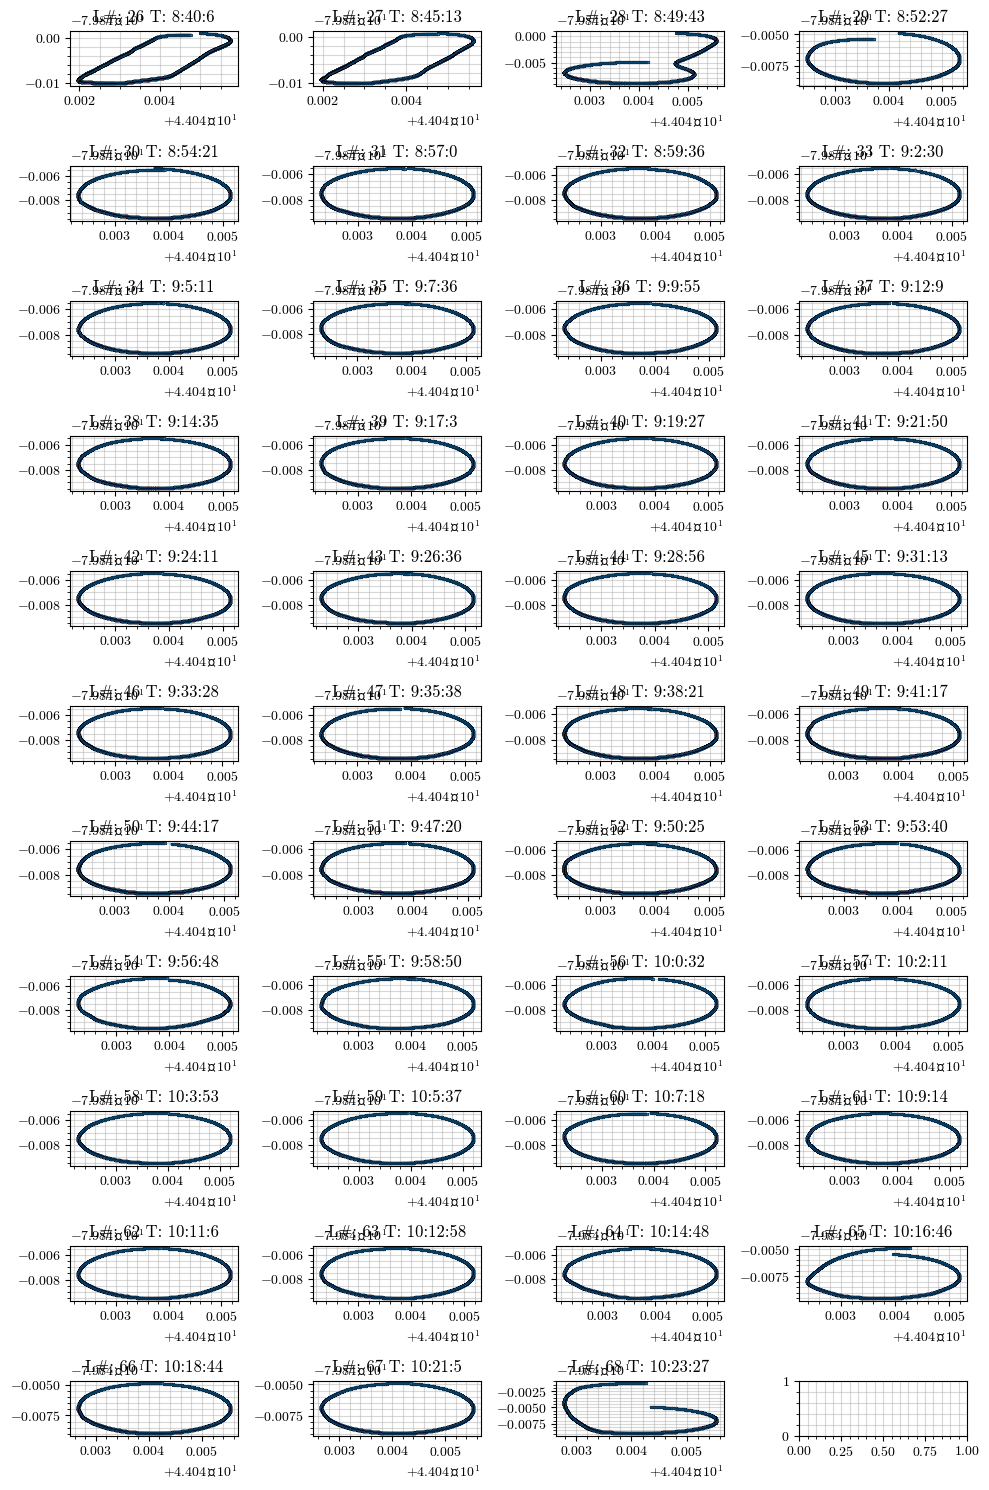

In [14]:
fig, axs = plt.subplots(int(np.ceil(loiter_numbers.size / 4)), 4)
axs = axs.flatten()

for i, loiter_number in enumerate(loiter_numbers):

    mask = cl_finders.mask_fromTime(df, loiter_times.index[loiter_number], loiter_times.index[loiter_number+1])
    segment = df[mask]
    segment["PowerElectrical"] = segment.EscVoltage * segment.EscCurrent

    durations = loiter_times.index.to_series().diff()
    print(durations[loiter_number+1])
    
    axs[i].plot(segment.Latitude, segment.Longitude)
    axs[i].set_title("L#: " + str(loiter_number) + " T: " + str(loiter_times.index[loiter_number].hour)+':'+str(loiter_times.index[loiter_number].minute)+':'+str(loiter_times.index[loiter_number].second))

    # Displaying Longitude/Lattitude for loiter
    # fig = px.scatter_mapbox(segment, 
    #                         lat="Latitude", 
    #                         lon="Longitude", 
    #                         hover_name=segment.index, 
    #                         #hover_data=["Address", "Listed"],
    #                         color="PowerElectrical",
    #                         color_continuous_scale='jet',
    #                         size="PowerElectrical",
    #                         zoom=15, 
    #                         height=500,
    #                         width=600)
    # fig.update_layout(mapbox_style="open-street-map")
    # fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    # fig.show()
    print(i)
fig.set_size_inches(10, 15)
plt.show()

## Developing the algorithm to sort out the loiter position (theta) from processed loiters

Selecting loiter 60 for testing on

### Steps:

1. Find the centroid of the loiter
   1. Find the maximum and minimum of the circle (lattitude and longitude)
   2. Take the midpoint between these to represent the centroid (not super complex)
2. Calculate the angle between the centroid and all sampled points in the loiter
   1. Numpy trigonometric functions (See equation below) tangent but with continuity taken into account

$ tan( \frac{y_p - y_0}{x_p - x_0}) = \theta $

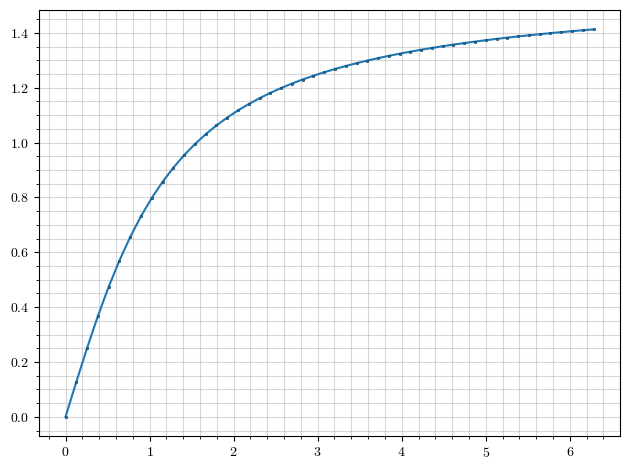

In [15]:
# Testing trig function to make sure that it'll work for all cases

x = np.linspace(0, 2 * np.pi)
y = np.arctan(x)

plt.figure()
plt.plot(x, y)
plt.show()

In [16]:
# Function for separating time indexed data by loiter number, and calculating loiter position

def loiter_show(df, loiter_times, segment_test, show=True):
    mask = cl_finders.mask_fromTime(df, loiter_times.index[segment_test], loiter_times.index[segment_test+1])
    segment = df[mask]

    lattitude = np.array(segment.Latitude)
    longitude = np.array(segment.Longitude)

    # print(np.max(lattitude))
    # print(np.min(lattitude))
    # print(np.max(longitude))
    # print(np.min(longitude))

    y0 = (np.max(lattitude) + np.min(lattitude)) * 0.5
    x0 = (np.max(longitude) + np.min(longitude)) * 0.5


    # Finding theta angles
    x_diffs = longitude - x0
    y_diffs = lattitude - y0

    thetas = np.arctan2(y_diffs, x_diffs) * 180 / np.pi
    thetas = np.where(thetas < 0, thetas+360, thetas)
    jump = np.diff(thetas)
    jump = np.abs(np.insert(jump, 0, -1, axis=0))
    boolean_jump = jump > 10
    jump_index = int(np.where(boolean_jump)[0])
    print(jump_index)
    thetas[jump_index:] = thetas[jump_index:] + 360

    if show:
        plt.figure()
        plt.plot(longitude, lattitude)
        plt.plot(x0, y0, marker='D')
        plt.plot(x0, np.max(lattitude), marker='D')
        plt.plot(x0, np.min(lattitude), marker='D')
        plt.plot(np.max(longitude), y0, marker='D')
        plt.plot(np.min(longitude), y0, marker='D')
        plt.show()

        plt.figure()
        plt.plot(thetas)
        plt.plot(jump)
        plt.show()

        plt.figure()
        plt.plot(thetas, segment.Groundspeed_GPS)
        plt.show()
    return thetas, segment

In [17]:
# Collecting the consecutive results of several loiters

theta_complete = np.array([])
segments_complete = pd.DataFrame()

for count, loiter_number in enumerate([55, 56, 57, 58, 59]):
    [thetas, segment_df] = loiter_show(df, loiter_times, loiter_number, show=False)
    thetas = thetas + (count * 360) # Increasing the theta angle by 360 degrees for subsequent loiters
    theta_complete = np.concatenate((theta_complete, thetas), axis=0)
    segments_complete = pd.concat([segments_complete, segment_df])

10039
9665
10109
10235
9919


In [18]:
# Curve fitting function for traditional fitting tools
    
def wind_model(theta, Vw_fit, Vinf_fit, phase_offset):
    # Note that theta is given in degrees!
    theta_rad = np.deg2rad(theta)
    Vg = Vinf_fit * np.sin(np.arccos((Vw_fit/Vinf_fit)*np.cos(theta_rad + phase_offset))) + Vw_fit*np.sin(theta_rad + phase_offset)
    return Vg

# Using the accumulated data from previous block to test the fitting abilities

Vg_actual = np.array(segments_complete.Groundspeed_GPS)
[pop_result, cov_result] = optimize.curve_fit(wind_model, theta_complete, Vg_actual, [5, 10, 0])

groundspeed_fit = wind_model(theta_complete, pop_result[0], pop_result[1], pop_result[2])
pop_result

array([ 5.52437315, 12.10648536,  1.14131878])

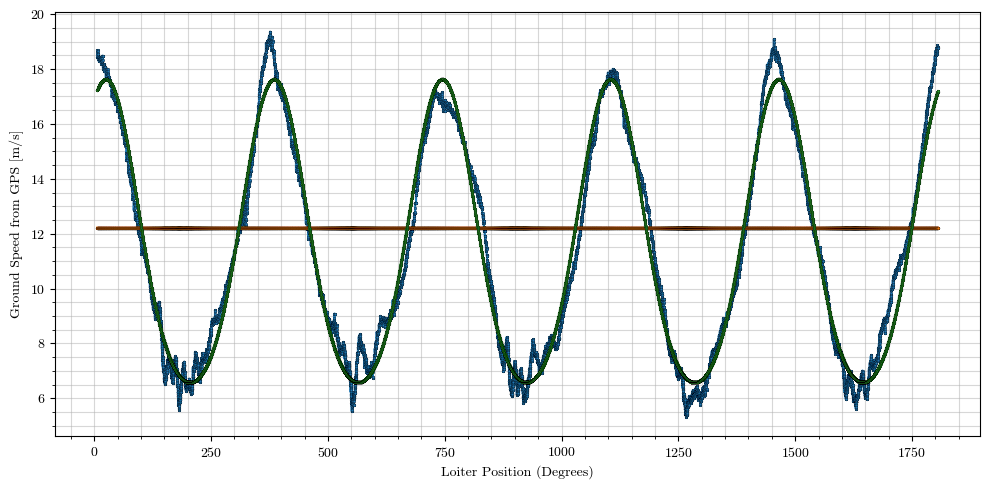

In [19]:
plt.figure(figsize=(10,5))
plt.plot(theta_complete, segments_complete.Groundspeed_GPS)
plt.plot(theta_complete, segments_complete.Airspeed_Demanded)
plt.plot(theta_complete, groundspeed_fit)
plt.xlabel("Loiter Position (Degrees)")
plt.ylabel("Ground Speed from GPS [m/s]")
plt.show()

11582
11116
11048
10957
11617


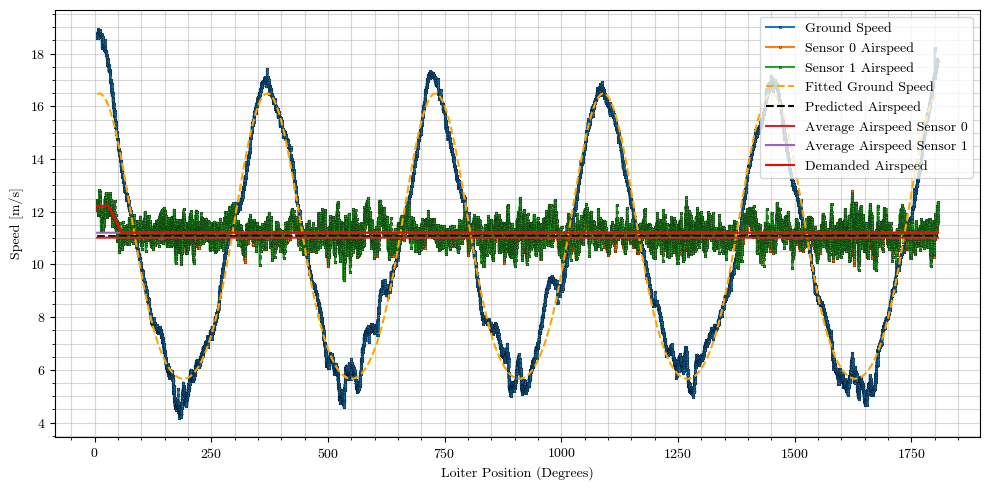

array([ 5.41225887, 11.07445341,  1.39173569])

In [20]:
theta_complete = np.array([])
segments_complete = pd.DataFrame()

for count, loiter_number in enumerate([60, 61, 62, 63, 64]):
    [thetas, segment_df] = loiter_show(df, loiter_times, loiter_number, show=False)
    thetas = thetas + (count * 360) # Increasing the theta angle by 360 degrees for subsequent loiters
    theta_complete = np.concatenate((theta_complete, thetas), axis=0)
    segments_complete = pd.concat([segments_complete, segment_df])

Vg_actual = np.array(segments_complete.Groundspeed_GPS)
[pop_result, cov_result] = optimize.curve_fit(wind_model, theta_complete, Vg_actual, [5, 10, 0])

groundspeed_fit = wind_model(theta_complete, pop_result[0], pop_result[1], pop_result[2])


plt.figure(figsize=(10,5))
plt.plot(theta_complete, segments_complete.Groundspeed_GPS, label="Ground Speed")
plt.plot(theta_complete, segments_complete.Airspeed_Sensor0, label="Sensor 0 Airspeed")
plt.plot(theta_complete, segments_complete.Airspeed_Sensor1, label="Sensor 1 Airspeed")
plt.plot(theta_complete, groundspeed_fit, marker='', linestyle='--', color='orange', label="Fitted Ground Speed")
plt.plot(theta_complete, np.ones(np.shape(theta_complete)) * pop_result[1], marker='', linestyle='--', color='black', label="Predicted Airspeed")
plt.plot(theta_complete, np.ones(np.shape(theta_complete)) * np.mean(segments_complete.Airspeed_Sensor0), marker='', linestyle='-', label="Average Airspeed Sensor 0")
plt.plot(theta_complete, np.ones(np.shape(theta_complete)) * np.mean(segments_complete.Airspeed_Sensor1), marker='', linestyle='-', label="Average Airspeed Sensor 1")

plt.plot(theta_complete, segments_complete.Airspeed_Demanded, marker='', color='red', label="Demanded Airspeed")

plt.legend(loc="upper right")
plt.xlabel("Loiter Position (Degrees)")
plt.ylabel("Speed [m/s]")
plt.show()
pop_result

13969
13999


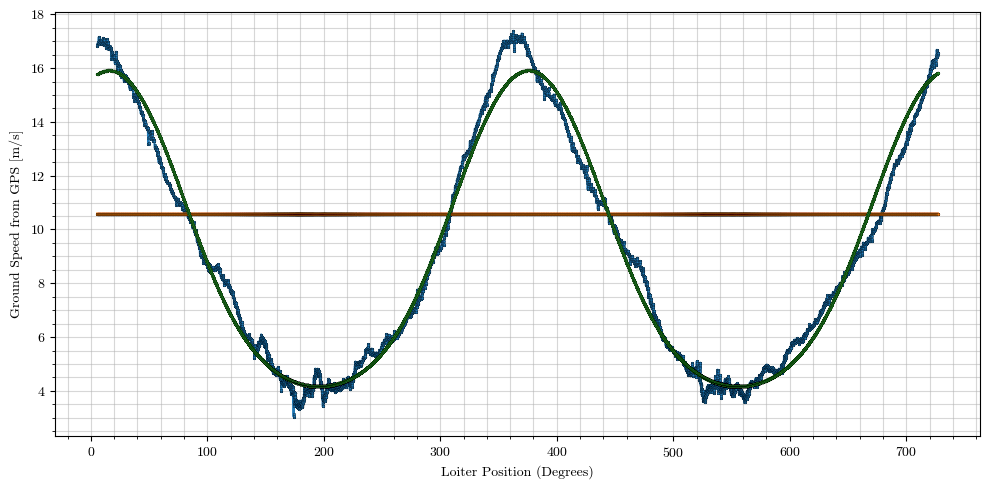

array([ 5.8705324 , 10.04389862,  1.29688246])

In [21]:
theta_complete = np.array([])
segments_complete = pd.DataFrame()

for count, loiter_number in enumerate([66, 67]):
    [thetas, segment_df] = loiter_show(df, loiter_times, loiter_number, show=False)
    thetas = thetas + (count * 360) # Increasing the theta angle by 360 degrees for subsequent loiters
    theta_complete = np.concatenate((theta_complete, thetas), axis=0)
    segments_complete = pd.concat([segments_complete, segment_df])

Vg_actual = np.array(segments_complete.Groundspeed_GPS)
[pop_result, cov_result] = optimize.curve_fit(wind_model, theta_complete, Vg_actual, [5, 10, 0])

groundspeed_fit = wind_model(theta_complete, pop_result[0], pop_result[1], pop_result[2])


plt.figure(figsize=(10,5))
plt.plot(theta_complete, segments_complete.Groundspeed_GPS)
plt.plot(theta_complete, segments_complete.Airspeed_Demanded)
plt.plot(theta_complete, groundspeed_fit)
plt.xlabel("Loiter Position (Degrees)")
plt.ylabel("Ground Speed from GPS [m/s]")
plt.show()
pop_result

14416
13728
13278
14439


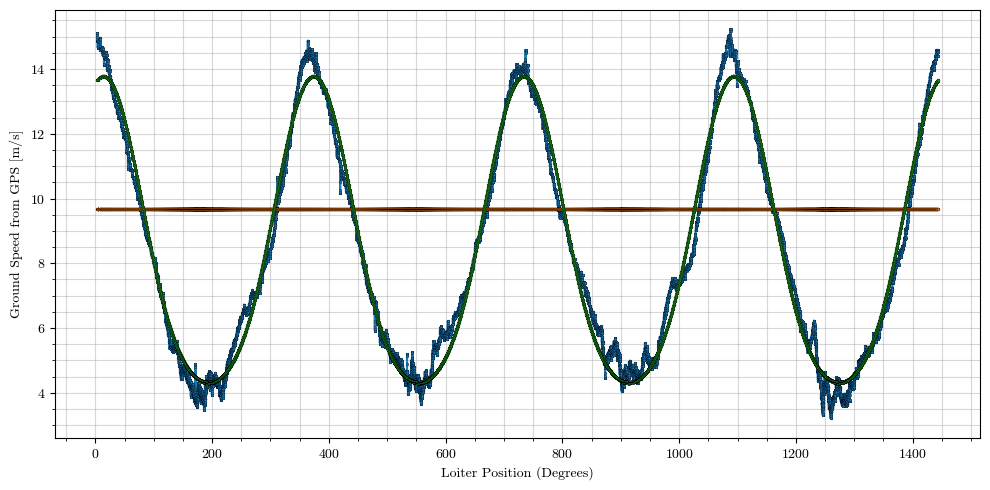

array([4.72885232, 9.04561982, 1.33331664])

In [22]:
theta_complete = np.array([])
segments_complete = pd.DataFrame()

list = np.arange(29,30)

for count, loiter_number in enumerate([34, 35, 36, 37]):
    [thetas, segment_df] = loiter_show(df, loiter_times, loiter_number, show=False)
    thetas = thetas + (count * 360) # Increasing the theta angle by 360 degrees for subsequent loiters
    theta_complete = np.concatenate((theta_complete, thetas), axis=0)
    segments_complete = pd.concat([segments_complete, segment_df])

Vg_actual = np.array(segments_complete.Groundspeed_GPS)
[pop_result, cov_result] = optimize.curve_fit(wind_model, theta_complete, Vg_actual, [5, 10, 0])

groundspeed_fit = wind_model(theta_complete, pop_result[0], pop_result[1], pop_result[2])


plt.figure(figsize=(10,5))
plt.plot(theta_complete, segments_complete.Groundspeed_GPS)
plt.plot(theta_complete, segments_complete.Airspeed_Demanded)
plt.plot(theta_complete, groundspeed_fit)
plt.xlabel("Loiter Position (Degrees)")
plt.ylabel("Ground Speed from GPS [m/s]")
plt.show()
pop_result

15758
15433
17292
16039


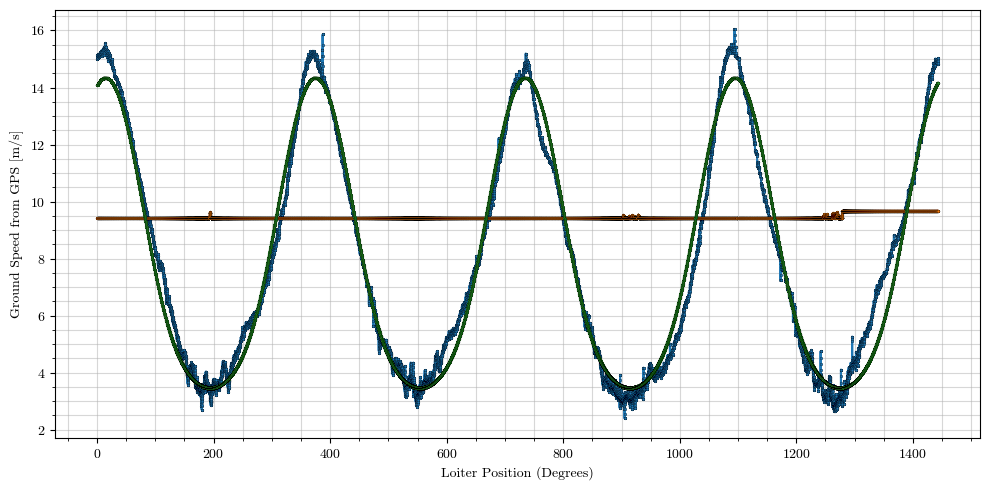

array([5.43937053, 8.90737661, 1.31871634])

In [23]:
theta_complete = np.array([])
segments_complete = pd.DataFrame()

list = np.arange(29,30)

for count, loiter_number in enumerate([30, 31, 32, 33]):
    [thetas, segment_df] = loiter_show(df, loiter_times, loiter_number, show=False)
    thetas = thetas + (count * 360) # Increasing the theta angle by 360 degrees for subsequent loiters
    theta_complete = np.concatenate((theta_complete, thetas), axis=0)
    segments_complete = pd.concat([segments_complete, segment_df])

Vg_actual = np.array(segments_complete.Groundspeed_GPS)
[pop_result, cov_result] = optimize.curve_fit(wind_model, theta_complete, Vg_actual, [5, 10, 0])

groundspeed_fit = wind_model(theta_complete, pop_result[0], pop_result[1], pop_result[2])


plt.figure(figsize=(10,5))
plt.plot(theta_complete, segments_complete.Groundspeed_GPS)
plt.plot(theta_complete, segments_complete.Airspeed_Demanded)
plt.plot(theta_complete, groundspeed_fit)
plt.xlabel("Loiter Position (Degrees)")
plt.ylabel("Ground Speed from GPS [m/s]")
plt.show()
pop_result

14242
14209
13949
14433


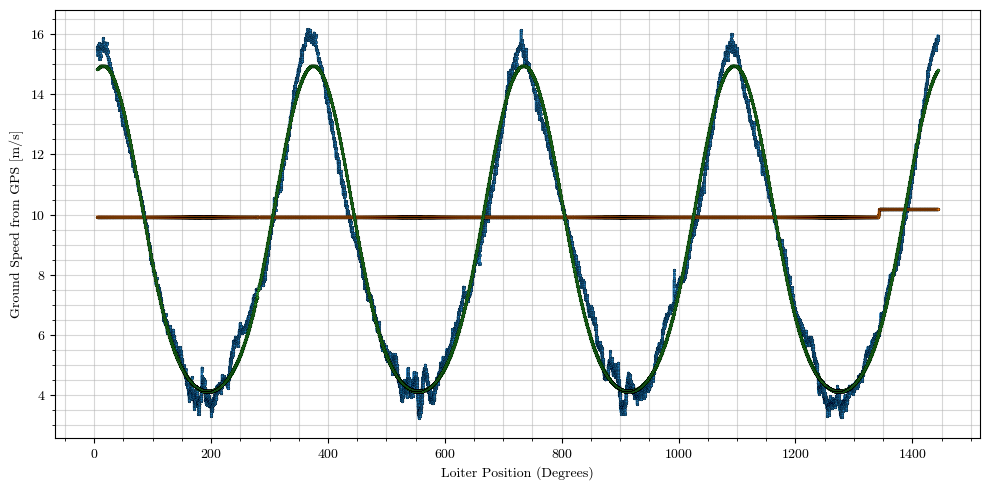

array([5.42143169, 9.53836202, 1.3158438 ])

In [24]:
theta_complete = np.array([])
segments_complete = pd.DataFrame()

list = np.arange(29,30)

for count, loiter_number in enumerate([39, 40, 41, 42]):
    [thetas, segment_df] = loiter_show(df, loiter_times, loiter_number, show=False)
    thetas = thetas + (count * 360) # Increasing the theta angle by 360 degrees for subsequent loiters
    theta_complete = np.concatenate((theta_complete, thetas), axis=0)
    segments_complete = pd.concat([segments_complete, segment_df])

Vg_actual = np.array(segments_complete.Groundspeed_GPS)
[pop_result, cov_result] = optimize.curve_fit(wind_model, theta_complete, Vg_actual, [5, 10, 0])

groundspeed_fit = wind_model(theta_complete, pop_result[0], pop_result[1], pop_result[2])


plt.figure(figsize=(10,5))
plt.plot(theta_complete, segments_complete.Groundspeed_GPS)
plt.plot(theta_complete, segments_complete.Airspeed_Demanded)
plt.plot(theta_complete, groundspeed_fit)
plt.xlabel("Loiter Position (Degrees)")
plt.ylabel("Ground Speed from GPS [m/s]")
plt.show()
pop_result

13795
13559
13453
12892


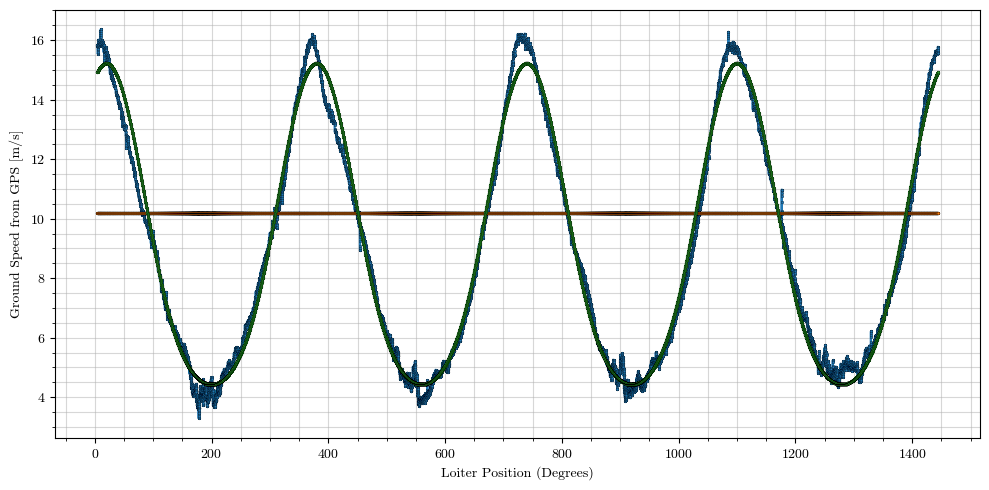

array([5.39708333, 9.82681683, 1.22974105])

In [25]:
theta_complete = np.array([])
segments_complete = pd.DataFrame()

list = np.arange(29,30)

for count, loiter_number in enumerate([43, 44, 45, 46]):
    [thetas, segment_df] = loiter_show(df, loiter_times, loiter_number, show=False)
    thetas = thetas + (count * 360) # Increasing the theta angle by 360 degrees for subsequent loiters
    theta_complete = np.concatenate((theta_complete, thetas), axis=0)
    segments_complete = pd.concat([segments_complete, segment_df])

Vg_actual = np.array(segments_complete.Groundspeed_GPS)
[pop_result, cov_result] = optimize.curve_fit(wind_model, theta_complete, Vg_actual, [5, 10, 0])

groundspeed_fit = wind_model(theta_complete, pop_result[0], pop_result[1], pop_result[2])


plt.figure(figsize=(10,5))
plt.plot(theta_complete, segments_complete.Groundspeed_GPS)
plt.plot(theta_complete, segments_complete.Airspeed_Demanded)
plt.plot(theta_complete, groundspeed_fit)
plt.xlabel("Loiter Position (Degrees)")
plt.ylabel("Ground Speed from GPS [m/s]")
plt.show()
pop_result

16199
17485
17703
18104


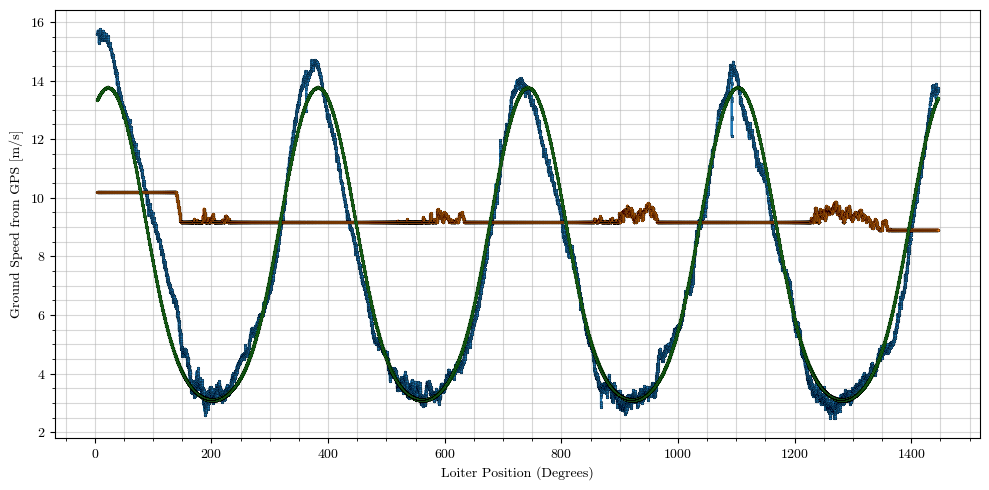

array([5.33246513, 8.43089379, 1.18492626])

In [26]:
theta_complete = np.array([])
segments_complete = pd.DataFrame()

list = np.arange(29,30)

for count, loiter_number in enumerate([47, 48, 49, 50]):
    [thetas, segment_df] = loiter_show(df, loiter_times, loiter_number, show=False)
    thetas = thetas + (count * 360) # Increasing the theta angle by 360 degrees for subsequent loiters
    theta_complete = np.concatenate((theta_complete, thetas), axis=0)
    segments_complete = pd.concat([segments_complete, segment_df])

Vg_actual = np.array(segments_complete.Groundspeed_GPS)
[pop_result, cov_result] = optimize.curve_fit(wind_model, theta_complete, Vg_actual, [5, 10, 0])

groundspeed_fit = wind_model(theta_complete, pop_result[0], pop_result[1], pop_result[2])


plt.figure(figsize=(10,5))
plt.plot(theta_complete, segments_complete.Groundspeed_GPS)
plt.plot(theta_complete, segments_complete.Airspeed_Demanded)
plt.plot(theta_complete, groundspeed_fit)
plt.xlabel("Loiter Position (Degrees)")
plt.ylabel("Ground Speed from GPS [m/s]")
plt.show()
pop_result

18104
18458
19209
18589


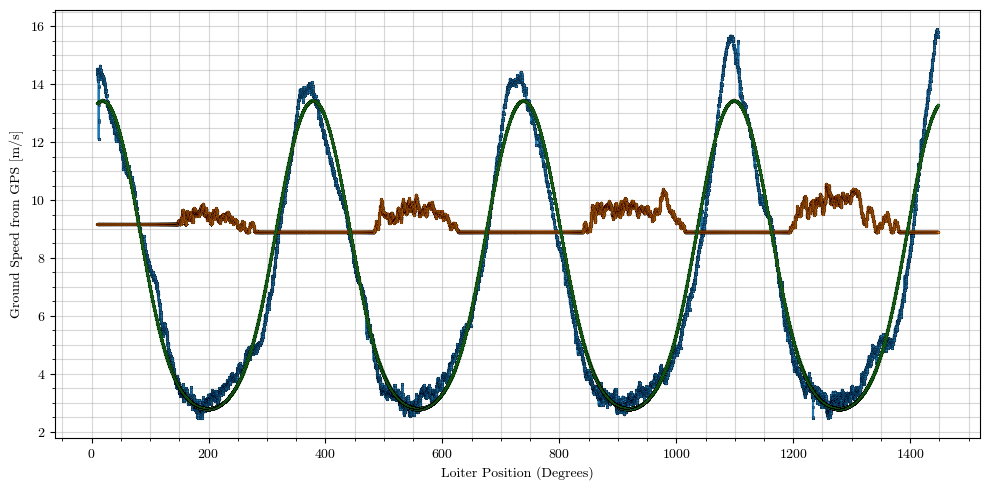

array([5.32369138, 8.11521577, 1.25284658])

In [27]:
theta_complete = np.array([])
segments_complete = pd.DataFrame()

list = np.arange(29,30)

for count, loiter_number in enumerate([50, 51, 52, 53]):
    [thetas, segment_df] = loiter_show(df, loiter_times, loiter_number, show=False)
    thetas = thetas + (count * 360) # Increasing the theta angle by 360 degrees for subsequent loiters
    theta_complete = np.concatenate((theta_complete, thetas), axis=0)
    segments_complete = pd.concat([segments_complete, segment_df])

Vg_actual = np.array(segments_complete.Groundspeed_GPS)
[pop_result, cov_result] = optimize.curve_fit(wind_model, theta_complete, Vg_actual, [5, 10, 0])

groundspeed_fit = wind_model(theta_complete, pop_result[0], pop_result[1], pop_result[2])


plt.figure(figsize=(10,5))
plt.plot(theta_complete, segments_complete.Groundspeed_GPS)
plt.plot(theta_complete, segments_complete.Airspeed_Demanded)
plt.plot(theta_complete, groundspeed_fit)
plt.xlabel("Loiter Position (Degrees)")
plt.ylabel("Ground Speed from GPS [m/s]")
plt.show()
pop_result

12038
10039
9665
10109
10235
9919
11582


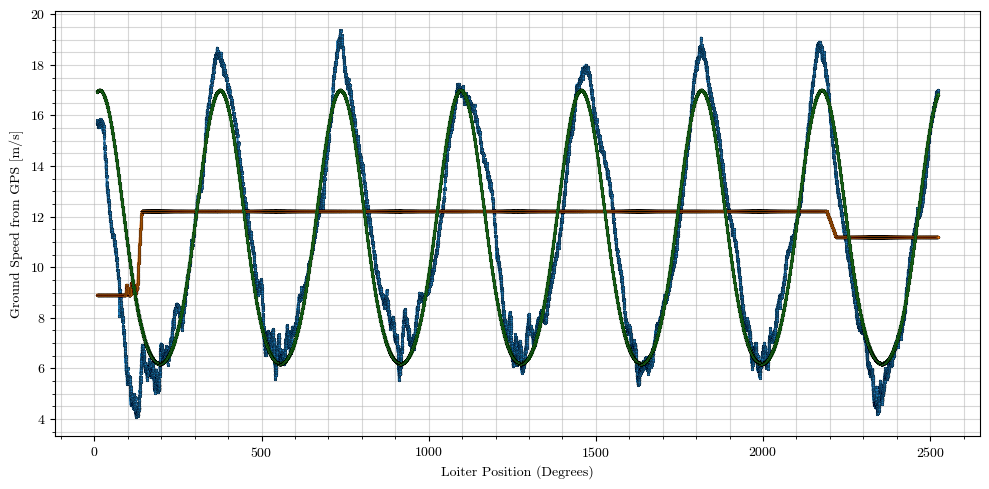

array([ 5.40592834, 11.59515851,  1.30308353])

In [28]:
theta_complete = np.array([])
segments_complete = pd.DataFrame()

list = np.arange(29,30)

for count, loiter_number in enumerate([54, 55, 56, 57, 58, 59, 60]):
    [thetas, segment_df] = loiter_show(df, loiter_times, loiter_number, show=False)
    thetas = thetas + (count * 360) # Increasing the theta angle by 360 degrees for subsequent loiters
    theta_complete = np.concatenate((theta_complete, thetas), axis=0)
    segments_complete = pd.concat([segments_complete, segment_df])

Vg_actual = np.array(segments_complete.Groundspeed_GPS)
[pop_result, cov_result] = optimize.curve_fit(wind_model, theta_complete, Vg_actual, [5, 10, 0])

groundspeed_fit = wind_model(theta_complete, pop_result[0], pop_result[1], pop_result[2])


plt.figure(figsize=(10,5))
plt.plot(theta_complete, segments_complete.Groundspeed_GPS)
plt.plot(theta_complete, segments_complete.Airspeed_Demanded)
plt.plot(theta_complete, groundspeed_fit)
plt.xlabel("Loiter Position (Degrees)")
plt.ylabel("Ground Speed from GPS [m/s]")
plt.show()
pop_result

12038
10039
9665
10109
10235
9919
11582


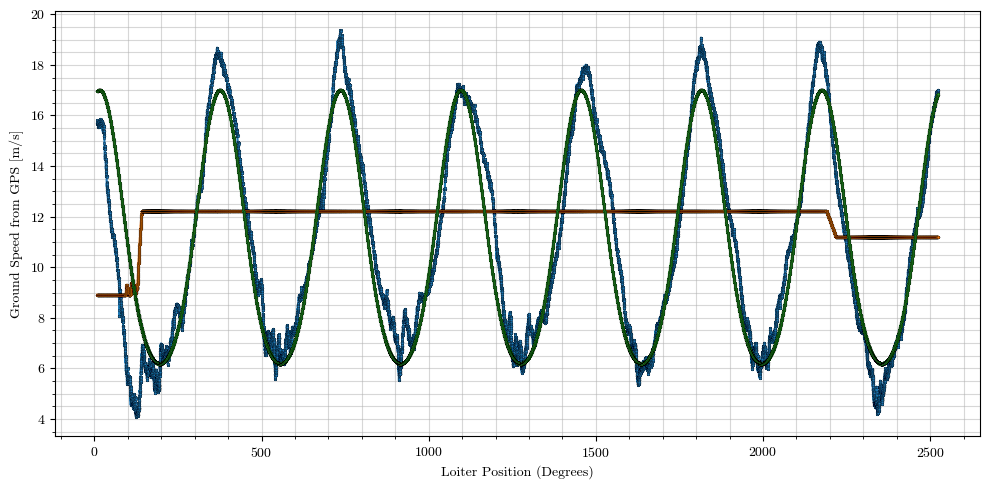

array([ 5.40592834, 11.59515851,  1.30308353])

In [29]:
# Trying Orthogonal Distance Regression Instead since it doesn't seem to capture the peaks well enough
theta_complete = np.array([])
segments_complete = pd.DataFrame()

list = np.arange(29,30)

for count, loiter_number in enumerate([54, 55, 56, 57, 58, 59, 60]):
    [thetas, segment_df] = loiter_show(df, loiter_times, loiter_number, show=False)
    thetas = thetas + (count * 360) # Increasing the theta angle by 360 degrees for subsequent loiters
    theta_complete = np.concatenate((theta_complete, thetas), axis=0)
    segments_complete = pd.concat([segments_complete, segment_df])

Vg_actual = np.array(segments_complete.Groundspeed_GPS)

# Defining curve fitting to the desired loiters
# B = Vw_fit, Vinf_fit, phase_offset
def wind_function(B, theta):
    # Note that theta is given in degrees!
    theta_rad = np.deg2rad(theta)
    Vg = B[1] * np.sin(np.arccos((B[0]/B[1])*np.cos(theta_rad + B[2]))) + B[0]*np.sin(theta_rad + B[2])
    return Vg

wind_model = odr.Model(wind_function)
data = odr.Data(theta_complete, Vg_actual)
myodr = odr.ODR(data, wind_model, beta0=[0, 10, 0])

output = myodr.run()
B = output.beta
B

groundspeed_fit = wind_function(B, theta_complete)


plt.figure(figsize=(10,5))
plt.plot(theta_complete, segments_complete.Groundspeed_GPS)
plt.plot(theta_complete, segments_complete.Airspeed_Demanded)
plt.plot(theta_complete, groundspeed_fit)
plt.xlabel("Loiter Position (Degrees)")
plt.ylabel("Ground Speed from GPS [m/s]")
plt.show()
pop_result